In [1]:
#======Libraries======
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
#======Function Definitions======
def dot_aligned(seq):
    """
    Aligns floating point values in a list to the decimal point.
    """
    snums = [str(n) for n in seq]
    dots = [s.find('.') for s in snums]
    m = max(dots)
    return [' '*(m - d) + s for s, d in zip(snums, dots)]

In [3]:
#======Initialization======
# Sets a random seed for NumPy and PyTorch
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Sets precision to 20 digits
torch.set_printoptions(precision = 20)
np.set_printoptions(precision = 20)

# Sets device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

First, we will use PyTorch to predict the temperature in celsius given the temperature in fahrenheit.

In [4]:
#======Data Loading======
df = pd.read_csv("data_fahrenheit_celsius.csv")     # Loads data
df.dropna(axis = 0, how = 'any', inplace = True)    # Drops invalid rows
display(df.head(10))

,Fahrenheit,Celsius
0,93.867673,34.041037
1,44.037903,7.128337
2,14.659180,-9.840604
3,32.573990,-0.582282
4,79.587177,27.304055
5,-18.156502,-28.599830
6,62.248431,16.988355
7,-34.921640,-37.432091
8,54.174503,13.291937
9,-23.058692,-30.759948


This is what the data looks like when we plot it. It is not a perfect line because a random number between -1 and 1 is added to the final value for each data point. This is to simulate real world data, as there will be random noise whenever we measure data.

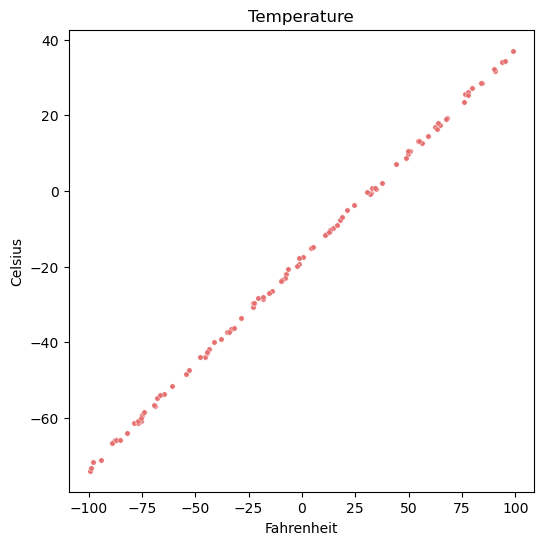

In [5]:
# Visualizes the data
plt.figure(figsize = (6, 6), dpi = 100)
sns.scatterplot(data = df, x = "Fahrenheit", y = "Celsius", s = 15, color = "#E67070")
plt.title("Temperature")
plt.show()

### Without Standardization

Usually, real-world data will have problems with it. For example, the data could be imbalanced or there may be a lot of 'holes' in it such as NULL values. There are techniques to deal with such discrepancies. For example, we can drop every entry in the dataframe where NULL values are present or we can impute new values to fill in the holes. In our case, the data is perfectly fine.

Features are columns whose values will be used as input for the machine learning model. Labels are columns whose values will be used to train the model's output(s). In our case, since we want to predict the temperature in Celsius based off degrees Fahrenheit, the Fahrenheit column will be the feature and the Celsius column will be the label.

Next, we split the data into training and testing sets. 80% of the data will be used for training and 20% of the data will be used for testing. We will skip standardizing our data for now.

In [6]:
#======Data Cleaning======
# Defines the features and labels
features = df["Fahrenheit"].values.reshape(-1, 1)
labels = df["Celsius"].values.reshape(-1, 1)

# Splits the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2)

# Creates a separate dataframe for the testing set to graph later (actual)
test_df_actual = pd.DataFrame({"Fahrenheit": x_test.flatten(), "Celsius": y_test.flatten()})

PyTorch's linear regression model has 2 main hyperparameters: learning rate and number of epochs.

The learning rate is a tuning parameter that determines the step size at each iteration while moving towards the minimum of the loss function. It affects precision. The value can be anywhere between 0 and 1. If the learning rate is too high, the training process may become unstable and crash. If the learning rate is too low, the model may never reach the minimum of the loss function.

The number of epochs controls the number of iterations the model goes through to train on the data. Generally, a larger number of epochs correlates with a higher degree of accuracy at the cost of CPU (or in our case, GPU) time.

In [7]:
#======Training======
# Hyperparameters
lr = 1e-4           # Learning rate
n_epochs = 30000    # Number of epochs

# Creates a model and sends it to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines a MSE loss function (ridge or L2 norm)
loss_fn = nn.MSELoss()

# Defines a stochastic gradient descent (SGD) optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr)

# Sets the model to training mode
model.train()

# Sends the training set to PyTorch
x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)

# Loops through the number of epochs
for epoch in range(n_epochs):
    # Computes the predicted output
    yhat = model(x_train)

    # Computes the loss using MSE
    loss = loss_fn(yhat, y_train)
    loss.backward()

    # Punishes the model based off the training set
    optimizer.step()
    optimizer.zero_grad()

# Prints the weight and bias after training
states = dot_aligned(["{:.20f}".format(value.cpu().detach().numpy().item()) for value in model.state_dict().values()])
print(f"Weight:\t{states[0]}")  # Should be   0.5556
print(f"Bias:\t{states[1]}")    # Should be -17.7778

Weight:	  0.55592572689056396484
Bias:	-17.87423515319824218750


We will now evaluate the outputs for our testing dataset. We will get a predicted set of outputs called `y_predicted`. Then, we will find the difference between these values and our actual values, `y_test`, and store them in the `comparison` array. If our predictions were accurate, then the median, mean, and standard deviation of the `comparison` array should be close to 0.

In [8]:
#======Testing======
# Sets the model to evaluation mode
model.eval()

# Sends the validation set to PyTorch
x_test = torch.from_numpy(x_test).float().to(device)

# Computes the predicted output
yhat = model(x_test)

# Gets the predicted output and compares it to the actual output
y_predicted = yhat.cpu().detach().numpy()
comparison = abs(y_predicted - y_test).flatten()

# Creates a dataframe for the testing set to graph later (predicted)
test_df_predicted = pd.DataFrame({"Fahrenheit": test_df_actual["Fahrenheit"], "Celsius": y_predicted.flatten()})

# Prints statistics
print("Testing set statistics")
print(f"Median:\t{np.median(comparison)}")
print(f"Mean:\t{np.mean(comparison)}")
print(f"STD:\t{np.std(comparison)}")

Testing set statistics
Median:	0.5420902432861361
Mean:	0.4995663666654872
STD:	0.30286413761328884


We will then generate new data outside the range of the training set and do the same thing. The reason for this is to check if the model actually learned the correlation between degrees Fahrenheit and degrees Celsius. If the newly generated data produces inaccurate predictions compared to the testing dataset, then the model would be overfitting on the data we trained it on. We want to avoid doing that. Since the range of the new data is 10 times greater than the range of the training data, we should expect to see slightly higher numbers for the median, mean, and standard deviation of the `comparison` array.

In actuality, the numbers are much closer to 0 than the one that the testing dataset produced. This is because our testing dataset had random noise in the output whereas the one we generated was a linear equation.

In [9]:
# Evaluates numbers outside of the training set
x_new = np.random.uniform(-1000, 1000, (100, 1))
y_new = (x_new - 32) / 1.8

# Creates a dataframe for the new testing set to graph later (actual)
new_df_actual = pd.DataFrame({"Fahrenheit": x_new.flatten(), "Celsius": y_new.flatten()})

# Sends the new set to PyTorch
x_new = torch.from_numpy(x_new).float().to(device)

# Computes the predicted output
yhat = model(x_new)

# Gets the predicted output and compares it to the actual output
y_predicted = yhat.cpu().detach().numpy()
comparison = abs(y_predicted - y_new).flatten()

# Creates a dataframe for the new testing set to graph later (predicted)
new_df_predicted = pd.DataFrame({"Fahrenheit": new_df_actual["Fahrenheit"], "Celsius": y_predicted.flatten()})

# Prints statistics
print("New set statistics")
print(f"Median:\t{np.median(comparison)}")
print(f"Mean:\t{np.mean(comparison)}")
print(f"STD:\t{np.std(comparison)}")

New set statistics
Median:	0.18417075399136706
Mean:	0.18699610017609777
STD:	0.12226472007921732


If looking at the `comparison` array and its sample statistics were not enough, we can also graph the data on top of the prediction line to see how accurate our model is. The better the line fits the points, the more accurate our model is.

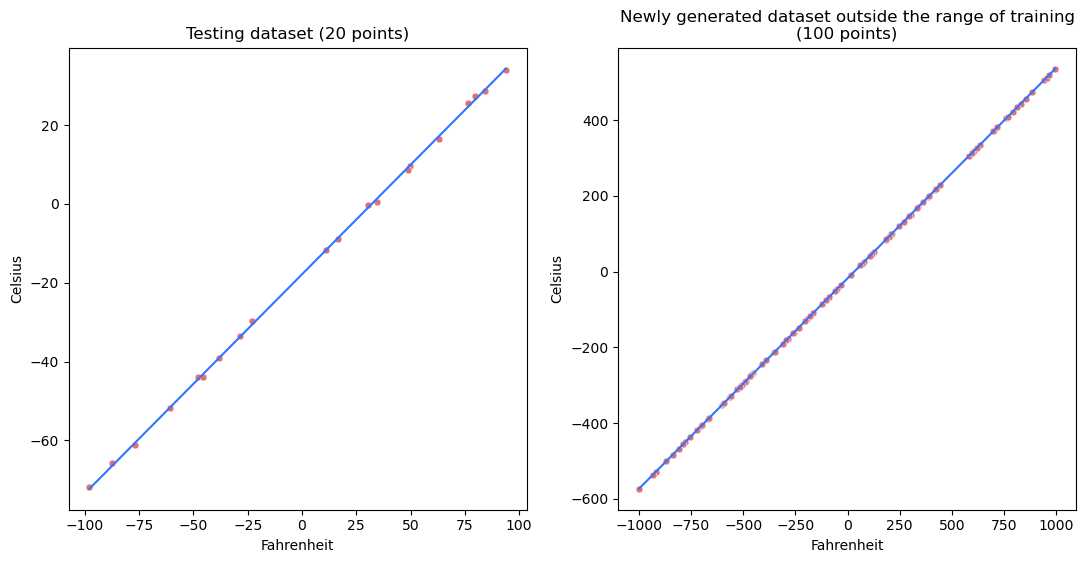

In [10]:
# Visualizes the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
sns.scatterplot(data = test_df_actual, x = "Fahrenheit", y = "Celsius", s = 25, color = "#E67070", ax = ax1)    # Testing points (actual)
sns.lineplot(data = test_df_predicted, x = "Fahrenheit", y = "Celsius", color = "#3075FF", ax = ax1)            # Testing line (predicted)
ax1.set_title("Testing dataset (20 points)")
sns.scatterplot(data = new_df_actual, x = "Fahrenheit", y = "Celsius", s = 25, color = "#E67070", ax = ax2)     # New points (actual)
sns.lineplot(data = new_df_predicted, x = "Fahrenheit", y = "Celsius", color = "#3075FF", ax = ax2)             # New line (predicted)
ax2.set_title("Newly generated dataset outside the range of training\n(100 points)")
plt.show()

### With Standardization

Now let us see what happens when we standardize the data. We will be using the standard scaler which should make the mean of the data 0 and the standard deviation 1.

In [11]:
#======Data Cleaning======
# Fits the data to the standard scaler
scaler = StandardScaler(with_mean=False)
scaler.fit(features)

# Defines the features and labels
features_scaled = scaler.transform(features)
labels_scaled = scaler.transform(labels)

# Splits the data into training and test sets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(features_scaled, labels_scaled, test_size = 0.2)

# Creates a separate dataframe for the testing set to graph later (actual)
test_df_actual = pd.DataFrame({"Fahrenheit": X_test_scaled.flatten(), "Celsius": y_test_scaled.flatten()})

We will use the same model as before with the same hyperparameters. Just train it on the standardized data.

In [12]:
#======Training======
# Sets the model to training mode
model.train()

# Sends the training set to PyTorch
X_train_scaled = torch.from_numpy(X_train_scaled).float().to(device)
y_train_scaled = torch.from_numpy(y_train_scaled).float().to(device)

# Loops through the number of epochs
for epoch in range(n_epochs):
    # Computes the predicted output
    yhat = model(X_train_scaled)

    # Computes the loss using MSE
    loss = loss_fn(yhat, y_train_scaled)
    loss.backward()

    # Punishes the model based off the training set
    optimizer.step()
    optimizer.zero_grad()

# Prints the weight and bias after training
states = dot_aligned(["{:.20f}".format(value.cpu().detach().numpy().item()) for value in model.state_dict().values()])
print(f"Weight:\t{states[0]}")  # Should be   0.5556
print(f"Bias:\t{states[1]}")    # Should be -17.7778

Weight:	 0.54834318161010742188
Bias:	-0.35831752419471740723


In [13]:
#======Testing======
# Sets the model to evaluation mode
model.eval()

# Sends the validation set to PyTorch
X_test_scaled = torch.from_numpy(X_test_scaled).float().to(device)

# Computes the predicted output
yhat = model(X_test_scaled)

# Gets the predicted output and compares it to the actual output
y_predicted = yhat.cpu().detach().numpy()
comparison = abs(y_predicted - y_test_scaled).flatten()

# Creates a dataframe for the testing set to graph later (predicted)
test_df_predicted = pd.DataFrame({"Fahrenheit": test_df_actual["Fahrenheit"], "Celsius": y_predicted.flatten()})

# Prints statistics
print("Testing set statistics")
print(f"Median:\t{np.median(comparison)}")
print(f"Mean:\t{np.mean(comparison)}")
print(f"STD:\t{np.std(comparison)}")

Testing set statistics
Median:	0.04252241135784722
Mean:	0.0439516899458269
STD:	0.010775552540253744


In [14]:
# Evaluates numbers outside of the training set
x_new = np.random.uniform(-1000, 1000, (100, 1))
y_new = (x_new - 32) / 1.8

# Creates a dataframe for the new testing set to graph later (actual)
new_df_actual = pd.DataFrame({"Fahrenheit": x_new.flatten(), "Celsius": y_new.flatten()})

# Sends the new set to PyTorch
x_new = torch.from_numpy(x_new).float().to(device)

# Computes the predicted output
yhat = model(x_new)

# Gets the predicted output and compares it to the actual output
y_predicted = yhat.cpu().detach().numpy()
comparison = abs(y_predicted - y_new).flatten()

# Creates a dataframe for the new testing set to graph later (predicted)
new_df_predicted = pd.DataFrame({"Fahrenheit": new_df_actual["Fahrenheit"], "Celsius": y_predicted.flatten()})

# Prints statistics
print("New set statistics")
print(f"Median:\t{np.median(comparison)}")
print(f"Mean:\t{np.mean(comparison)}")
print(f"STD:\t{np.std(comparison)}")

New set statistics
Median:	18.923420638063547
Mean:	18.33950259533176
STD:	4.262082403826034


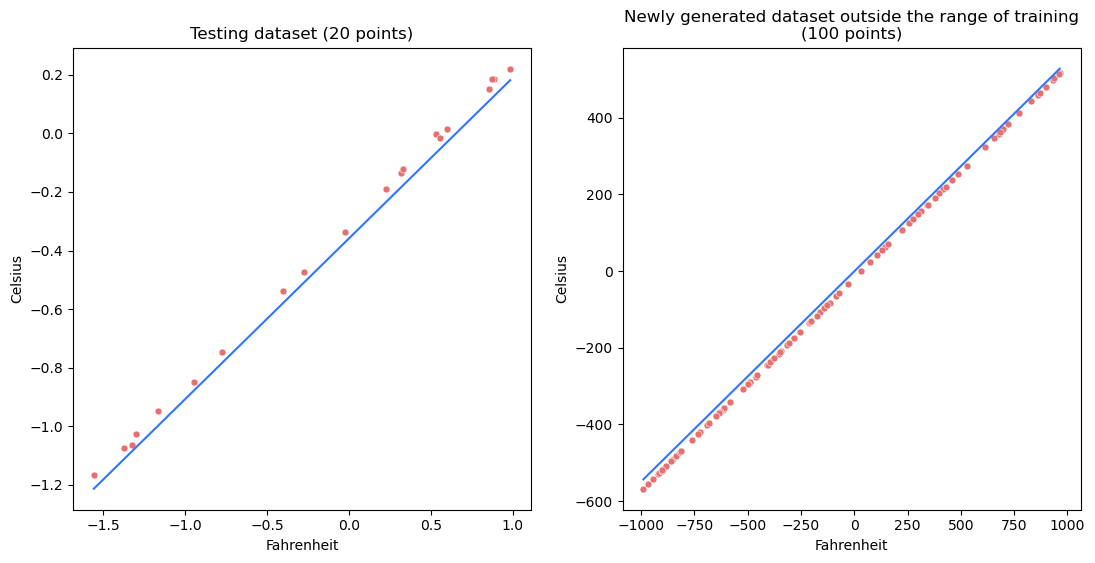

In [15]:
# Visualizes the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
sns.scatterplot(data = test_df_actual, x = "Fahrenheit", y = "Celsius", s = 25, color = "#E67070", ax = ax1)    # Testing points (actual)
sns.lineplot(data = test_df_predicted, x = "Fahrenheit", y = "Celsius", color = "#3075FF", ax = ax1)            # Testing line (predicted)
ax1.set_title("Testing dataset (20 points)")
sns.scatterplot(data = new_df_actual, x = "Fahrenheit", y = "Celsius", s = 25, color = "#E67070", ax = ax2)     # New points (actual)
sns.lineplot(data = new_df_predicted, x = "Fahrenheit", y = "Celsius", color = "#3075FF", ax = ax2)             # New line (predicted)
ax2.set_title("Newly generated dataset outside the range of training\n(100 points)")
plt.show()